In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize

In [2]:
data = pd.read_csv("C:/Users/stanl/Downloads/marketing_data.csv")

In [3]:
data['Date'] = pd.to_datetime(data['Date'])

data.head()

,Date,Sales,TV,Digital,Social Media,TV_AdStock,Digital_AdStock,Social Media_AdStock
0,2024-01-01,132.641940,249.816048,254.441055,165.706319,249.816048,254.441055,165.706319
1,2024-01-02,185.147579,480.285723,484.476226,425.829888,630.175351,560.808542,492.112416
2,2024-01-03,211.417249,392.797577,462.140257,366.078888,770.902787,630.382819,562.923855
3,2024-01-04,179.297924,339.463394,178.316454,309.226170,802.005066,367.431300,534.395712
4,2024-01-05,159.977462,162.407456,127.744520,243.532194,643.610496,237.973910,457.290478


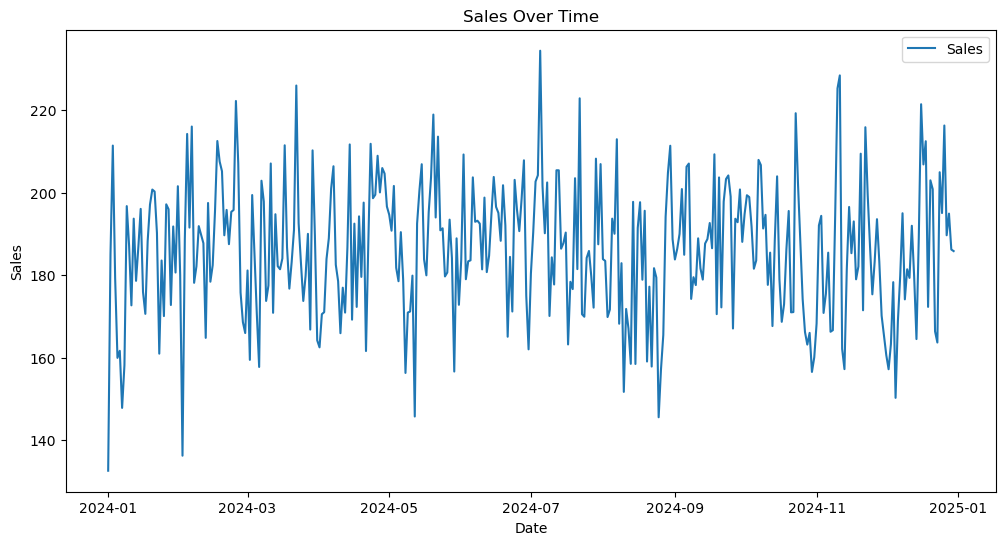

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Sales'], label='Sales')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [5]:
correlation_matrix = data.corr()
print("Correlation Matrix:")
print(correlation_matrix['Sales'].sort_values(ascending=False))

Correlation Matrix:
Sales                   1.000000
Digital_AdStock         0.603464
Digital                 0.574319
TV_AdStock              0.473062
TV                      0.349183
Social Media_AdStock    0.251984
Social Media            0.212198
Name: Sales, dtype: float64


C:\Users\stanl\AppData\Local\Temp\ipykernel_35120\2137934619.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


In [6]:
# --- Ad Stock Transformation with Decay ---
def ad_stock(spend, decay_rate):
    ad_stock = np.zeros(len(spend))
    ad_stock[0] = spend[0]
    for t in range(1, len(spend)):
        ad_stock[t] = spend[t] + decay_rate * ad_stock[t-1]
    return ad_stock


In [7]:
def optimize_decay_rate(channel_spend, sales):
    def objective(decay_rate):
        ad_stock_values = ad_stock(channel_spend, decay_rate)
        return mean_squared_error(sales, ad_stock_values)
    result = minimize(objective, x0=0.5, bounds=[(0, 1)])
    return result.x[0]

In [8]:
optimized_decay_rates = {}
ad_stock_data = {}
for channel in ['TV', 'Digital', 'Social Media']:
    optimized_decay_rates[channel] = optimize_decay_rate(data[channel], data['Sales'])
    ad_stock_data[f"{channel}_AdStock"] = ad_stock(data[channel], optimized_decay_rates[channel])

In [9]:
data = data.assign(**ad_stock_data)

In [10]:
features = ['TV_AdStock', 'Digital_AdStock', 'Social Media_AdStock']
target = 'Sales'

X = data[features]
y = data[target]

In [11]:
from sklearn.ensemble import RandomForestRegressor

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [13]:
y_pred = model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [14]:
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

Root Mean Squared Error (RMSE): 11.70
R-squared (R2): 0.48


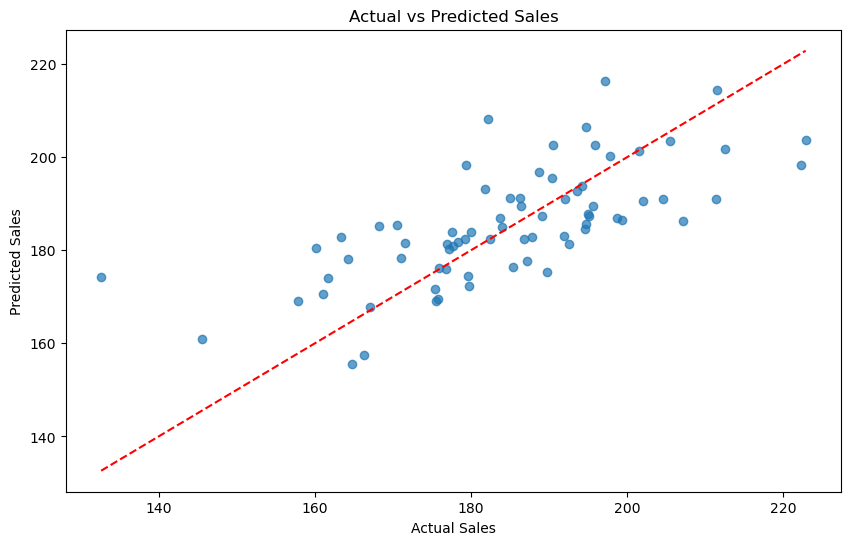

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.title('Actual vs Predicted Sales')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.show()

In [16]:
feature_importances = model.feature_importances_
importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(importances_df)


Feature Importances:
                Feature  Importance
1       Digital_AdStock     0.49943
0            TV_AdStock     0.29224
2  Social Media_AdStock     0.20833


In [ ]:
importances_df.to_csv('feature_importances.csv', index=False)
#SAve the importances